# 🏡 California Housing Price Classification

## 🎯 Objective
The goal of this project is to build a machine learning model that classifies housing prices in California into three categories: **Low**, **Medium**, and **High**.

We will leverage **Decision Trees** and **Ensemble Methods (Bagging & Random Forest)**, optimizing their hyperparameters using **Bayesian Optimization (Optuna)** to achieve maximum accuracy.

## 🛠️ Key Techniques
- **Data Preprocessing:** Binning continuous values & Standardization.
- **Feature Engineering:** Creating geospatial features (Rotated Coordinates, Distance to LA/SF).
- **Hyperparameter Tuning:** Using **Optuna** for efficient Bayesian Optimization.
- **Evaluation:** Comparing models using Accuracy, Confusion Matrices, and Feature Importance.

# Setup and Data Loading
Importing necessary libraries and loading the California Housing dataset.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, cross_val_score
import optuna
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from optuna.samplers import TPESampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
sns.set(style = 'whitegrid')
import warnings
warnings.filterwarnings('ignore')

In [2]:
housing = fetch_california_housing(as_frame = True)

In [3]:
df = housing.data.copy()
df['MedHouseValue'] = housing.target

# Exploratory Data Analysis (EDA) & Feature Engineering
Creating new features to help the model understand the geographical context better:
- **Rotated Coordinates:** To capture diagonal relationships in California's geography.
- **Distance to Major Cities:** Calculating distance to Los Angeles and San Francisco.

In [ ]:
# Cap the number of rooms and bedrooms to avoid extreme outliers affecting the model
df['AveRooms'] = np.clip(df['AveRooms'], 0, 10)
df['AveBedrms'] = np.clip(df['AveBedrms'], 0, 5)

# Calculate the proportion of bedrooms to total rooms (House Layout)
df['Bedroom_Ratio'] = df['AveBedrms'] / df['AveRooms']

# Calculate available personal space (Privacy Metric)
df['Rooms_Per_Person'] = df['AveRooms'] / df['AveOccup']

# Rotate coordinates to help tree models capture diagonal geographic trends (like the coastline)
df['Rotated_Coords_1'] = df['Latitude'] + df['Longitude']
df['Rotated_Coords_2'] = df['Latitude'] - df['Longitude']

# Function to calculate Euclidean distance
def calculate_distance(lat, lon, city_lat, city_lon):
        return np.sqrt((lat - city_lat) ** 2 + (lon - city_lon) ** 2)

# Calculate distance to major economic hubs (Los Angeles and San Francisco)
# Proximity to these cities is a massive driver of house prices
df['Dist_to_LA'] = calculate_distance(df['Latitude'], df['Longitude'], 34.05, -118.24)
df['Dist_to_SF'] = calculate_distance(df['Latitude'], df['Longitude'], 37.77, -122.41)

# Preprocessing & Data Splitting 
Converting the continuous `MedianHouseValue` into categorical classes (Low, Medium, High) and visualizing the distribution.

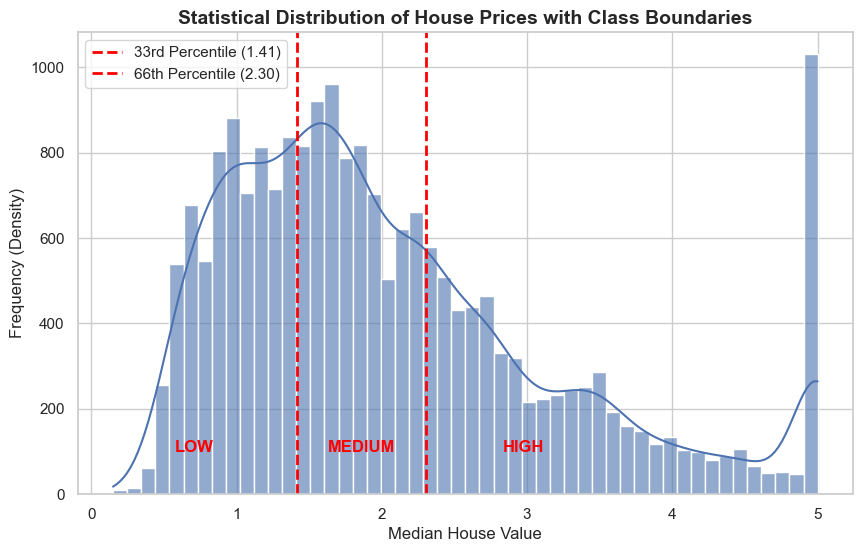

In [ ]:
q1 = df['MedHouseValue'].quantile(1/3)
q2 = df['MedHouseValue'].quantile(2/3)

plt.figure(figsize = (10, 6))

sns.histplot(df['MedHouseValue'], kde = True, bins = 50, colo= '#4c72b0', alpha = 0.6)

plt.axvline(q1, color = 'red', linestyle = '--', linewidth = 2, label = f'33rd Percentile ({q1:.2f})')
plt.axvline(q2, color = 'red', linestyle = '--', linewidth = 2, label = f'66th Percentile ({q2:.2f})')

plt.text(q1/2, 100, 'LOW', fontsize = 12, fontweight = 'bold', color = 'red', ha = 'center')
plt.text((q1+q2)/2, 100, 'MEDIUM', fontsize = 12, fontweight = 'bold', color = 'red', ha = 'center')
plt.text(q2 + (df['MedHouseValue'].max() - q2)/4, 100, 'HIGH', fontsize = 12, fontweight = 'bold', color = 'red', ha = 'center')

plt.title('Statistical Distribution of House Prices with Class Boundaries', fontsize = 14, fontweight = 'bold')
plt.xlabel('Median House Value', fontsize = 12)
plt.ylabel('Frequency (Density)', fontsize = 12)
plt.legend()
plt.show()

In [9]:
X = df.drop(columns = ['MedHouseValue'])
y = pd.qcut(df['MedHouseValue'], q = 3, labels = [0, 1, 2])

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [11]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model Optimization with Optuna
Using Bayesian Optimization to find the best hyperparameters for Decision Tree, Bagging, and Random Forest models.

In [12]:
def objective_dt(trial):
    
    param = {
        'max_depth': trial.suggest_int('max_depth', 10, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20), 
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 21),   
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy']),
        'max_features': trial.suggest_float('max_features', 0.2, 1.0),
        'ccp_alpha': trial.suggest_float('ccp_alpha', 0.0, 0.005)

        
    }

    model = DecisionTreeClassifier(**param, random_state = 42)

    scores = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring='accuracy')
    
    return scores.mean()

In [13]:
print("--- Start Tuning Decision Tree ---")
study_dt = optuna.create_study(sampler = TPESampler(seed = 41), direction = 'maximize') 
study_dt.optimize(objective_dt, n_trials = 30) 
best_params_dt = study_dt.best_params
print("Best DT Params:", best_params_dt)

[I 2025-11-28 14:06:06,599] A new study created in memory with name: no-name-a415c09d-41e5-425a-8ac2-63f541de98da


--- Start Tuning Decision Tree ---


[I 2025-11-28 14:06:07,190] Trial 0 finished with value: 0.7756181677248424 and parameters: {'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 15, 'criterion': 'entropy', 'max_features': 0.6830925511590505, 'ccp_alpha': 0.0009546533138986957}. Best is trial 0 with value: 0.7756181677248424.
[I 2025-11-28 14:06:07,440] Trial 1 finished with value: 0.7432177271071048 and parameters: {'max_depth': 37, 'min_samples_split': 19, 'min_samples_leaf': 9, 'criterion': 'gini', 'max_features': 0.34902581391857956, 'ccp_alpha': 0.0015855523524331532}. Best is trial 0 with value: 0.7756181677248424.
[I 2025-11-28 14:06:07,906] Trial 2 finished with value: 0.7388558168858111 and parameters: {'max_depth': 29, 'min_samples_split': 3, 'min_samples_leaf': 15, 'criterion': 'entropy', 'max_features': 0.5185702367065795, 'ccp_alpha': 0.003041132297615244}. Best is trial 0 with value: 0.7756181677248424.
[I 2025-11-28 14:06:08,372] Trial 3 finished with value: 0.7392200581927887 and parameters: {'

Best DT Params: {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 0.8348308342417816, 'ccp_alpha': 0.0002815029393378188}


In [14]:
# Best DT Params: {'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 5, 'criterion': 'gini', 'max_features': 0.8791401797921271, 'ccp_alpha': 0.00027951824097866983} ==> 0.7859
best_dt = DecisionTreeClassifier(**best_params_dt, random_state = 42)
best_dt.fit(X_train_scaled, y_train)
y_pred_dt = best_dt.predict(X_test_scaled)
acc_dt = accuracy_score(y_test, y_pred_dt)

In [15]:
print(f"Decision Tree Test Accuracy: {acc_dt:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_dt))

Decision Tree Test Accuracy: 0.7955
Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.85      0.85      1378
           1       0.71      0.73      0.72      1390
           2       0.84      0.80      0.82      1360

    accuracy                           0.80      4128
   macro avg       0.80      0.80      0.80      4128
weighted avg       0.80      0.80      0.80      4128



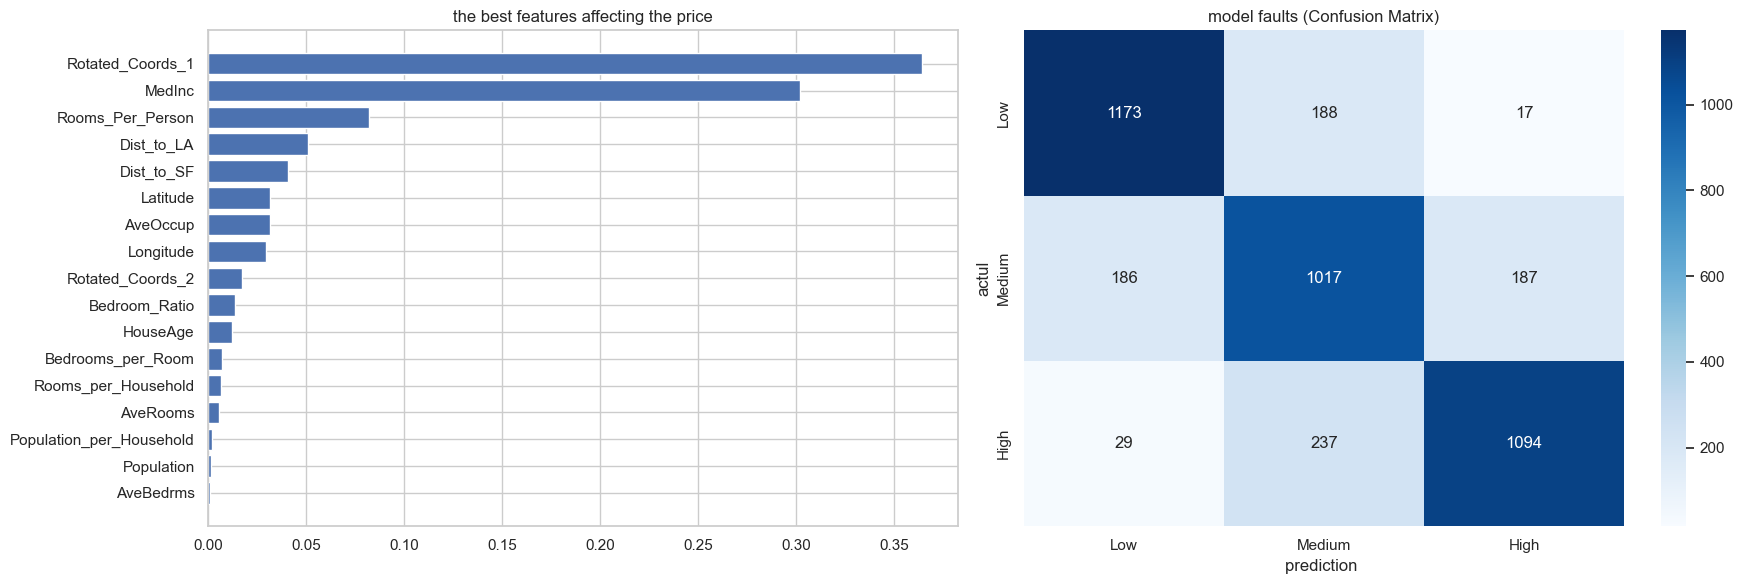

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

importances = best_dt.feature_importances_
names = X.columns
indices = np.argsort(importances)

ax[0].barh(range(len(indices)), importances[indices], color='#4c72b0')
ax[0].set_yticks(range(len(indices)))
ax[0].set_yticklabels(names[indices])
ax[0].set_title('the best features affecting the price')

cm = confusion_matrix(y_test, y_pred_dt)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax[1],
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
ax[1].set_title('model faults (Confusion Matrix)')
ax[1].set_xlabel('prediction ')
ax[1].set_ylabel('actul')

plt.tight_layout()
plt.show()

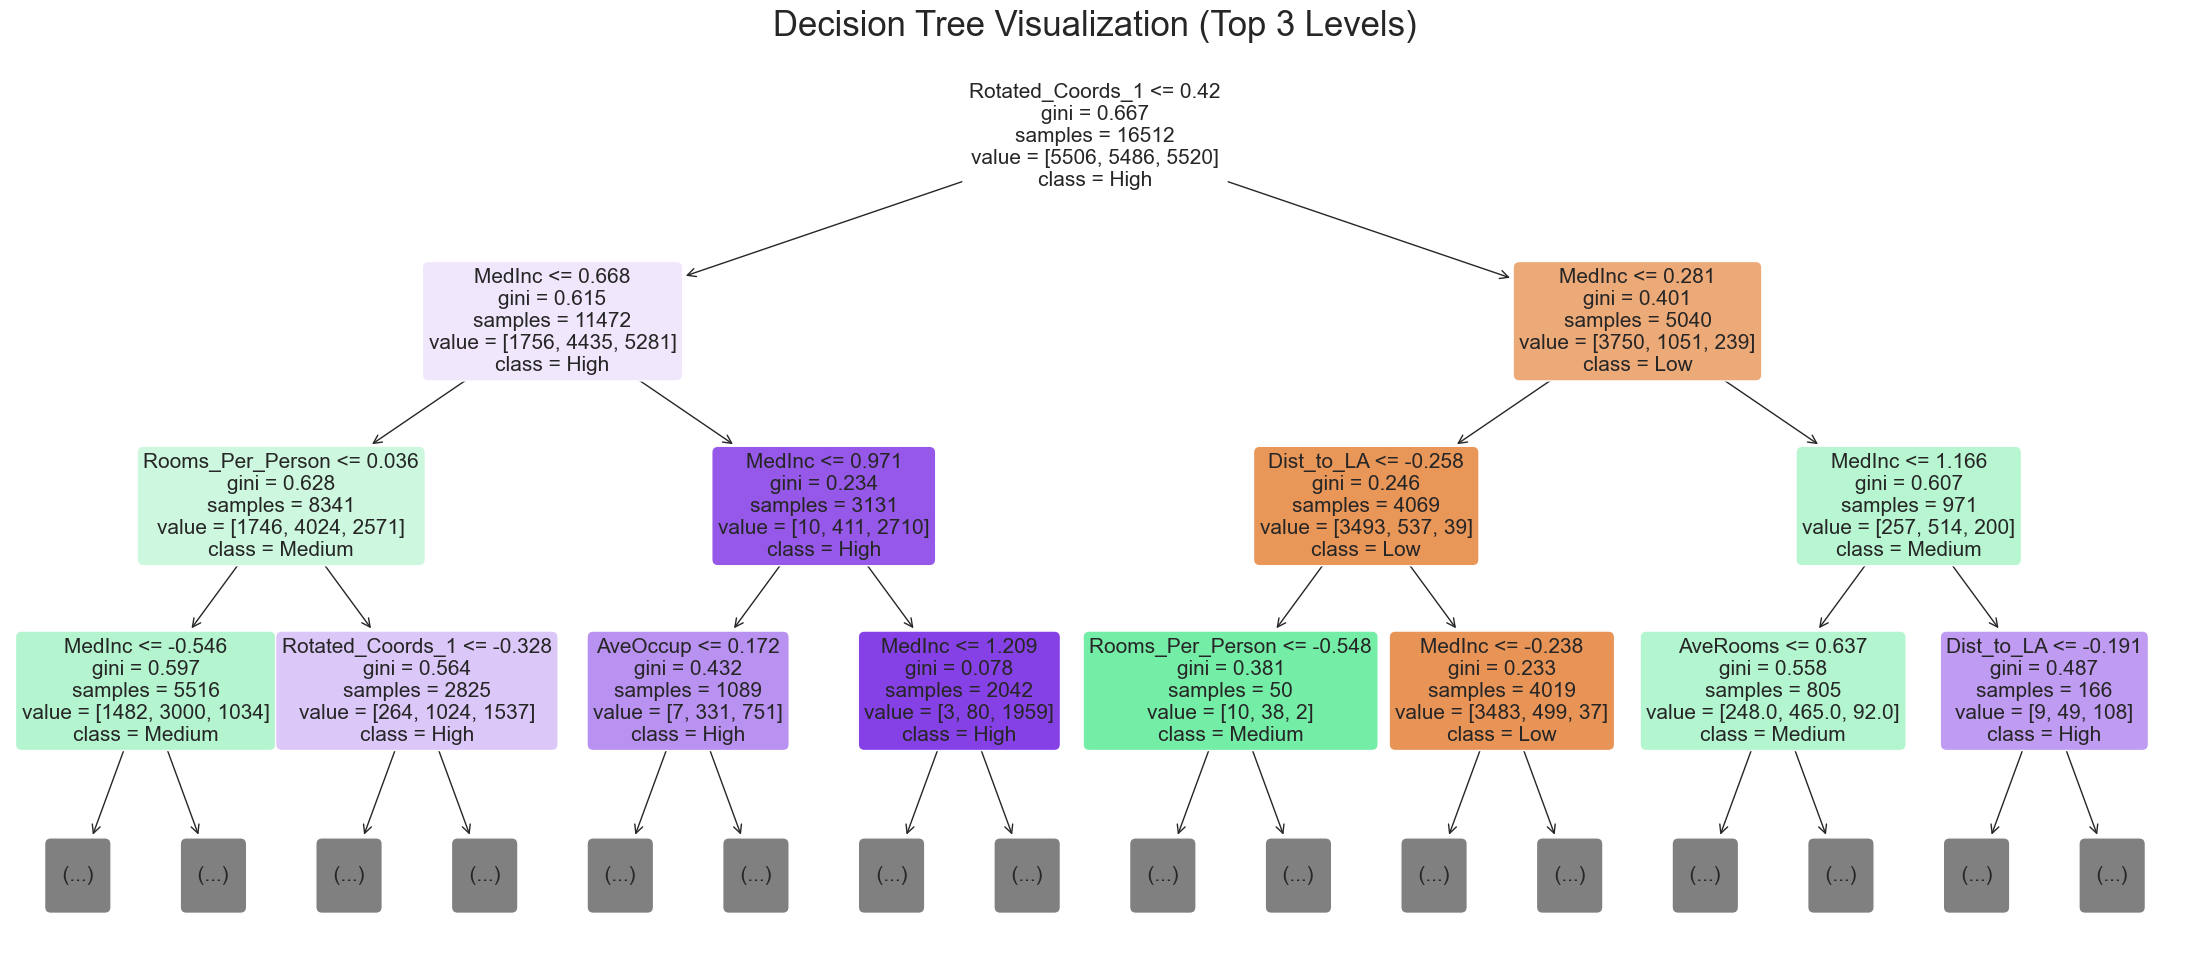

In [17]:
plt.figure(figsize=(28, 12))

plot_tree(
    best_dt,               
    feature_names = X.columns, 
    class_names = ['Low', 'Medium', 'High'],
    filled = True,                
    rounded = True,               
    fontsize = 15,               
    max_depth = 3                
)

plt.title("Decision Tree Visualization (Top 3 Levels)", fontsize = 25)
plt.show()

In [42]:
def objective_rf(trial):
    
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        # 'max_depth': trial.suggest_int('max_depth', 30, 100),
        'max_depth': None,
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 4),
        
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', 'sqrt']),
        'bootstrap': trial.suggest_categorical('bootstrap', [True]),
        'class_weight': trial.suggest_categorical('class_weight', [None]),
        'criterion': trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    }

    model = RandomForestClassifier(**param, random_state = 42, n_jobs = -1)

    scores = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring='accuracy', n_jobs = -1)
    
    return scores.mean()

In [43]:
print("--- Start Tuning Random Forest ---")
study_rf = optuna.create_study(sampler = TPESampler(seed = 41), direction = 'maximize') 
study_rf.optimize(objective_rf, n_trials = 30) 
best_params_rf = study_rf.best_params
print("Best RF Params:", best_params_rf)

[I 2025-11-28 14:38:52,073] A new study created in memory with name: no-name-c66a8354-d35d-47f2-bf23-9188a3fd7d1b


--- Start Tuning Random Forest ---


[I 2025-11-28 14:39:01,672] Trial 0 finished with value: 0.8326672721768089 and parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss'}. Best is trial 0 with value: 0.8326672721768089.
[I 2025-11-28 14:39:11,374] Trial 1 finished with value: 0.8328489985702111 and parameters: {'n_estimators': 267, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8328489985702111.
[I 2025-11-28 14:39:23,956] Trial 2 finished with value: 0.8321827723745809 and parameters: {'n_estimators': 398, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None, 'criterion': 'entropy'}. Best is trial 1 with value: 0.8328489985702111.
[I 2025-11-28 14:39:33,976] Trial 3 finished with value: 0.8329095129090838 and parameters: {'n_estima

Best RF Params: {'n_estimators': 452, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'bootstrap': True, 'class_weight': None, 'criterion': 'log_loss'}


In [44]:
best_rf = RandomForestClassifier(**best_params_rf, random_state = 42)
best_rf.fit(X_train_scaled, y_train)
y_pred_rf = best_rf.predict(X_test_scaled)
acc_rf = accuracy_score(y_test, y_pred_rf)

In [45]:
print(f"Random Forest Test Accuracy: {acc_rf:.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred_rf))

Random Forest Test Accuracy: 0.8442
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.89      0.89      1378
           1       0.77      0.79      0.78      1390
           2       0.88      0.85      0.87      1360

    accuracy                           0.84      4128
   macro avg       0.85      0.84      0.85      4128
weighted avg       0.85      0.84      0.84      4128



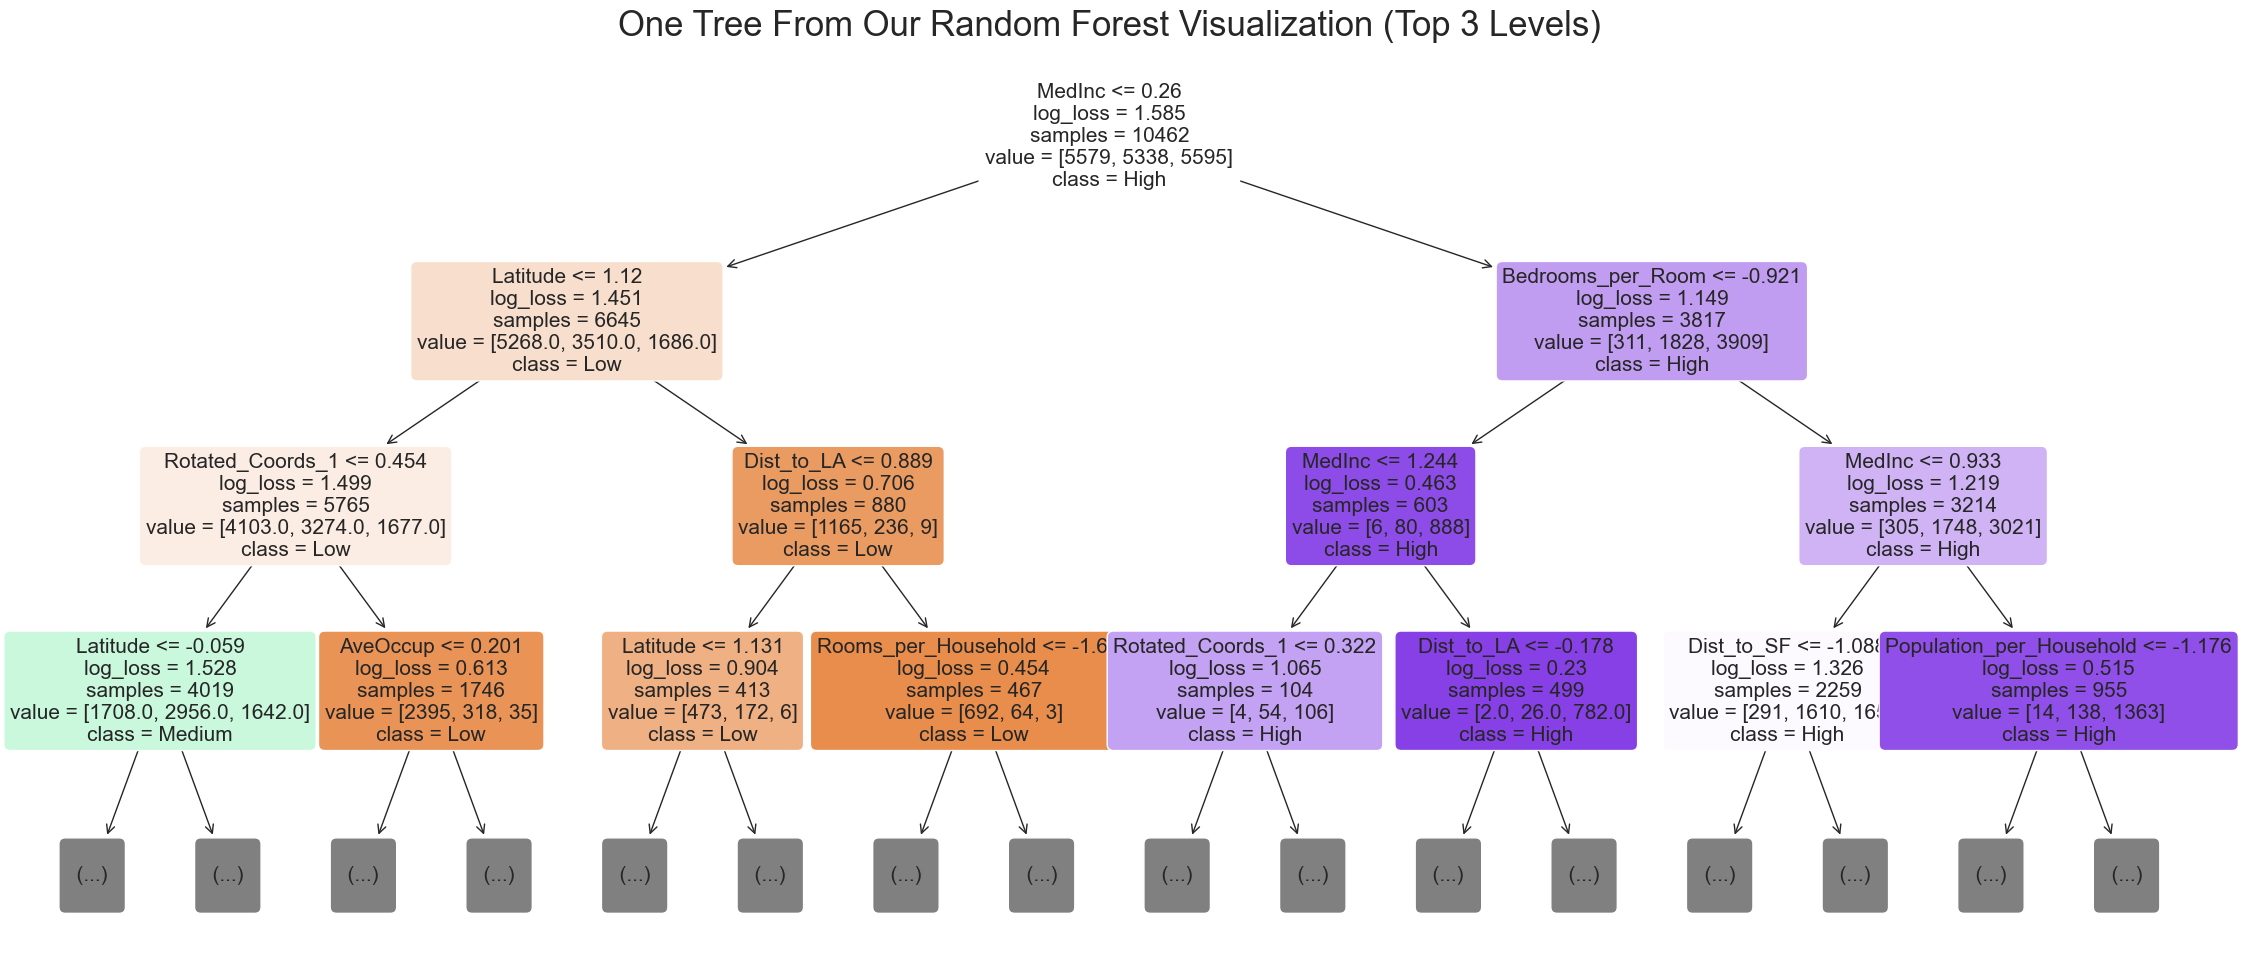

In [46]:
plt.figure(figsize=(28, 12))

plot_tree(
    best_rf.estimators_[0],               
    feature_names = X.columns, 
    class_names = ['Low', 'Medium', 'High'],
    filled = True,                
    rounded = True,               
    fontsize = 15,               
    max_depth = 3                
)

plt.title("One Tree From Our Random Forest Visualization (Top 3 Levels)", fontsize = 25)
plt.show()

In [23]:
def objective_bagging(trial):
   
    dt_max_depth = trial.suggest_int('base_max_depth', 5, 25)
    n_estimators = trial.suggest_int('n_estimators', 10, 100) 
    max_samples = trial.suggest_float('max_samples', 0.5, 1.0) 
    max_features = trial.suggest_float('max_features', 0.5, 1.0)
    base_estimator = DecisionTreeClassifier(max_depth = dt_max_depth)
    
    model = BaggingClassifier(
        estimator=base_estimator,
        n_estimators=n_estimators,
        max_samples=max_samples,
        max_features=max_features,
        random_state=42,
        n_jobs=-1
    )
    
    scores = cross_val_score(model, X_train_scaled, y_train, cv = 5, scoring = 'accuracy')
    return scores.mean()

In [24]:
print("\n--- Start Tuning Bagging Classifier ---")
study_bagging = optuna.create_study(sampler = TPESampler(seed = 41), direction = 'maximize')
study_bagging.optimize(objective_bagging, n_trials=30)
best_params_bagging = study_bagging.best_params
print("Best Bagging Params:", best_params_bagging)

[I 2025-11-28 14:13:29,831] A new study created in memory with name: no-name-5fedfb20-edc0-4f72-82af-0668282706d9



--- Start Tuning Bagging Classifier ---


[I 2025-11-28 14:13:31,252] Trial 0 finished with value: 0.8132266740604186 and parameters: {'base_max_depth': 10, 'n_estimators': 14, 'max_samples': 0.8384081205552791, 'max_features': 0.521734742822376}. Best is trial 0 with value: 0.8132266740604186.
[I 2025-11-28 14:13:34,444] Trial 1 finished with value: 0.7905158260583178 and parameters: {'base_max_depth': 7, 'n_estimators': 64, 'max_samples': 0.5954653313898696, 'max_features': 0.8342578586301729}. Best is trial 0 with value: 0.8132266740604186.
[I 2025-11-28 14:13:37,614] Trial 2 finished with value: 0.8283065905799714 and parameters: {'base_max_depth': 24, 'n_estimators': 48, 'max_samples': 0.6661299250238714, 'max_features': 0.6415168175858633}. Best is trial 2 with value: 0.8283065905799714.
[I 2025-11-28 14:13:39,637] Trial 3 finished with value: 0.811046874223514 and parameters: {'base_max_depth': 8, 'n_estimators': 38, 'max_samples': 0.7405843344078876, 'max_features': 0.5347602339058027}. Best is trial 2 with value: 0.82

Best Bagging Params: {'base_max_depth': 25, 'n_estimators': 66, 'max_samples': 0.9730338793759749, 'max_features': 0.5091721089534844}


In [25]:
base_depth = best_params_bagging.pop('base_max_depth')
base_est = DecisionTreeClassifier(max_depth = base_depth)

best_bagging = BaggingClassifier(
    estimator=base_est,
    **best_params_bagging,
    random_state=42,
    n_jobs=-1
)
best_bagging.fit(X_train_scaled, y_train)
y_pred_bagging = best_bagging.predict(X_test_scaled)
acc_bagging = accuracy_score(y_test, y_pred_bagging)

In [26]:
print(f"Bagging Model Test Accuracy: {acc_bagging:.4f}")
print(classification_report(y_test, y_pred_bagging, target_names=['Low', 'Medium', 'High']))

Bagging Model Test Accuracy: 0.8457
              precision    recall  f1-score   support

         Low       0.88      0.90      0.89      1378
      Medium       0.78      0.78      0.78      1390
        High       0.88      0.86      0.87      1360

    accuracy                           0.85      4128
   macro avg       0.85      0.85      0.85      4128
weighted avg       0.85      0.85      0.85      4128



# Final Evaluation & Results
Comparing the accuracy of tuned models and analyzing Feature Importance.

In [47]:
dt_default = DecisionTreeClassifier(random_state=42)
dt_default.fit(X_train_scaled, y_train)
acc_dt_default = accuracy_score(y_test, dt_default.predict(X_test_scaled))

print(f"--- Decision Tree ---")
print(f"Default Accuracy: {acc_dt_default:.4f}")
print(f"Tuned Accuracy:   {acc_dt:.4f}")
print(f"Improvement:      {(acc_dt - acc_dt_default)*100:.2f}%\n")

bagging_default = BaggingClassifier(random_state=42)
bagging_default.fit(X_train_scaled, y_train)
acc_bagging_default = accuracy_score(y_test, bagging_default.predict(X_test_scaled))

print(f"--- Bagging Classifier ---")
print(f"Default Accuracy: {acc_bagging_default:.4f}")
print(f"Tuned Accuracy:   {acc_bagging:.4f}") 
print(f"Improvement:      {(acc_bagging - acc_bagging_default)*100:.2f}%\n")

rf_default = RandomForestClassifier(random_state = 42)
rf_default.fit(X_train_scaled, y_train)
acc_rf_default = accuracy_score(y_test, rf_default.predict(X_test_scaled))

print(f"--- Random Forest ---")
print(f"Default Accuracy: {acc_rf_default:.4f}")
print(f"Tuned Accuracy:   {acc_rf:.4f}")
print(f"Improvement:      {(acc_rf - acc_rf_default)*100:.2f}%\n")

results_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Bagging', 'Random Forest'],
    'Default Accuracy': [acc_dt_default, acc_bagging_default, acc_rf_default],
    'Tuned Accuracy': [acc_dt, acc_bagging, acc_rf],
    'Improvement (%)': [
        (acc_dt - acc_dt_default)*100,
        (acc_bagging - acc_bagging_default)*100,
        (acc_rf - acc_rf_default)*100
    ]
})

print("\n=== Final Performance Summary ===")
display(results_df)

--- Decision Tree ---
Default Accuracy: 0.7597
Tuned Accuracy:   0.7955
Improvement:      3.59%

--- Bagging Classifier ---
Default Accuracy: 0.8140
Tuned Accuracy:   0.8457
Improvement:      3.17%

--- Random Forest ---
Default Accuracy: 0.8471
Tuned Accuracy:   0.8442
Improvement:      -0.29%


=== Final Performance Summary ===


,Model,Default Accuracy,Tuned Accuracy,Improvement (%)
0,Decision Tree,0.759690,0.795543,3.585271
1,Bagging,0.813953,0.845688,3.173450
2,Random Forest,0.847141,0.844234,-0.290698


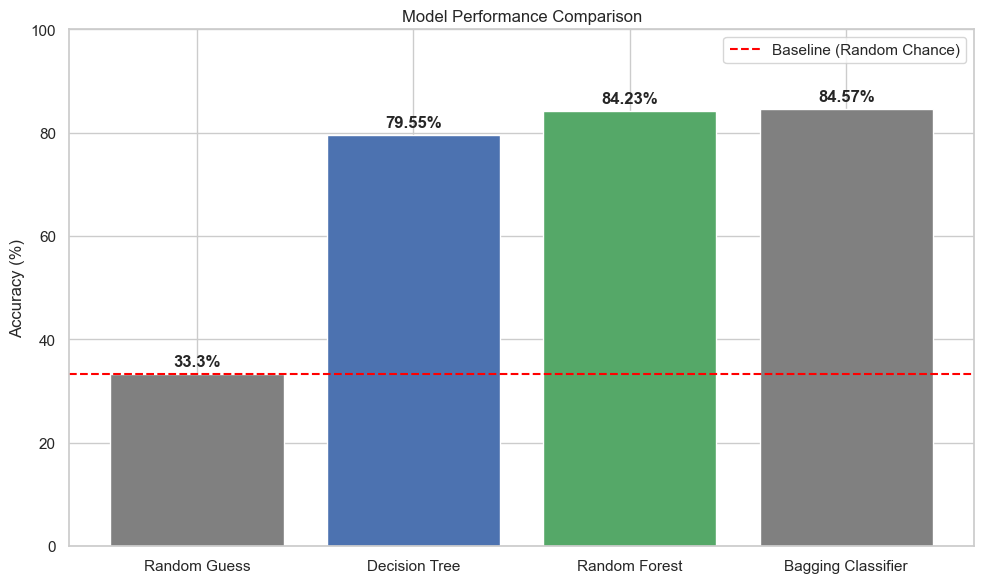

In [ ]:
models = ['Random Guess', 'Decision Tree', 'Random Forest', 'Bagging Classifier']
accuracies = [33.3, 79.55, 84.23, 84.57]
colors = ['gray', '#4c72b0', '#55a868']

plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=colors)

plt.axhline(y=33.3, color='red', linestyle='--', label='Baseline (Random Chance)')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 1, f'{yval}%', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.ylim(0, 100)
plt.ylabel('Accuracy (%)')
plt.title('Model Performance Comparison')
plt.legend()
plt.tight_layout()

In [51]:
import joblib

final_model = best_bagging 

joblib.dump(final_model, 'housing_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

print("Model and Scaler saved successfully!")

Model and Scaler saved successfully!


# 🏁 Conclusion

In this project, we successfully classified California housing prices with high accuracy.
- **Best Model:** [Bagging Classifier] achieved an accuracy of **[84.57%]%**.
- **Key Insight:** The **Median Income** and **Location (Distance to cities)** were the most critical factors in determining house prices.
- **Optimization:** Optuna proved effective in fine-tuning the models compared to default parameters.